In [1]:
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import scipy.stats as stat
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy import stats
import pickle
from sklearn.metrics import *
import pandas as pd
import seaborn as sns
import statsmodels

In [2]:
from all_models import *
#from transfer_models import *

In [3]:
# read fit values
#fits_single = pickle.load(open('fit_single_CV_704.pickle', 'rb'))
#fits_dual = pickle.load(open('fit_dual_CV_704.pickle', 'rb'))
#fits_avg = pickle.load(open('fit_dual_fastavg_CV_704.pickle', 'rb'))
#fits_eight = pickle.load(open('fit_dual_eight_CV_704.pickle', 'rb'))
#fits_alpha = pickle.load(open('fit_dual_2alpha_CV_704.pickle', 'rb'))
#fits_six = pickle.load(open('fit_six_CV_704.pickle', 'rb'))
#fits_mixed = pickle.load(open('fit_mixed_CV_704.pickle', 'rb'))
fits_single = pickle.load(open('fit_single_CV_640_avgstartparam.pickle', 'rb'))
fits_dual = pickle.load(open('fit_dual_CV_640_avgstartparam.pickle', 'rb'))
fits_hybrid = pickle.load(open('fit_hybrid_CV_704.pickle', 'rb'))
#fits_single_transfer = pickle.load(open('fit_single_CV_transfer.pickle', 'rb'))
#fits_dual_transfer = pickle.load(open('fit_dual_CV_transfer.pickle', 'rb'))

curvatures_smooth = pickle.load(open('curvatures_smooth.pickle', 'rb'))
curvatures_smooth = curvatures_smooth/90.0
curvatures = pickle.load(open('curvatures.pickle', 'rb'))

In [3]:
fits = pickle.load(open('fit_single_start_640.pickle', 'rb'))

In [4]:
fits_single = np.vstack(fits[:, 0])
fits_dual = np.vstack(fits[:, 1])

In [5]:
for participant in range(60):
    if fits_dual[participant, -1] > fits_single[participant, -1]:
        fits_dual[participant, -1] = fits_single[participant, -1]
lr = (fits_single[:, -1]-fits_dual[:, -1])

In [11]:
AIC_single = fits_single[:, -1] + 4
AIC_dual = fits_dual[:, -1] + 8

BIC_single = fits_single[:, -1] + 2*np.log(640)
BIC_dual = fits_dual[:, -1] + 4*np.log(640)

In [59]:
p_val = stat.chi2.sf(lr, 2)

In [13]:
np.where(BIC_single > BIC_dual)

(array([ 1,  8, 15, 17, 21, 25, 32, 33, 37, 49, 52, 53, 57, 59],
       dtype=int64),)

In [60]:
np.where(p_val < 0.05)

(array([ 1,  8, 13, 15, 17, 21, 25, 32, 33, 37, 49, 52, 53, 57, 59],
       dtype=int64),)

In [4]:
curvatures_smooth = pickle.load(open('avg_smooth.pickle', 'rb'))
curvatures_smooth = curvatures_smooth/90

In [44]:
for participant in range(60):
    np.nan_to_num(np.ravel(curvatures[participant][1:]), nan = np.nanmedian(curvatures[participant][1:]))

In [5]:
num_itr = 100

num_trials = 704
model_errors_dual = np.zeros((num_itr, 60, num_trials))
model_errors_single = np.zeros((num_itr, 60, num_trials))
model_errors_hybrid = np.zeros((num_itr, 60, num_trials))
#model_errors_dual_704 = np.zeros((num_itr, 60, 704))
#model_errors_single_704 = np.zeros((num_itr, 60, 704))
#model_errors_avg = np.zeros((num_itr, 60, 704))
#model_errors_eight = np.zeros((num_itr, 60, 704))
#model_errors_alpha = np.zeros((num_itr, 60, 704))

for i in range(num_itr):
    for participant in range(60):
        if participant%4 == 0 or participant%4 == 1:

            model_errors_dual[i][participant]  = dual_model_sudden(num_trials, fits_dual[i][participant][0], fits_dual[i][participant][1], fits_dual[i][participant][2], fits_dual[i][participant][3])[0]
            model_errors_single[i][participant] = model_sudden(num_trials, fits_single[i][participant][0], fits_single[i][participant][1])[0]
        
        else:
            
            model_errors_dual[i][participant] = dual_model_gradual(num_trials, fits_dual[i][participant][0], fits_dual[i][participant][1], fits_dual[i][participant][2], fits_dual[i][participant][3])[0]
            model_errors_single[i][participant] = model_gradual(num_trials, fits_single[i][participant][0], fits_single[i][participant][1])[0]
        model_errors_hybrid[i][participant] = fits_hybrid[i][participant][0]*model_errors_single[i][participant] + (1 - fits_hybrid[i][participant][0])*model_errors_dual[i][participant]


        

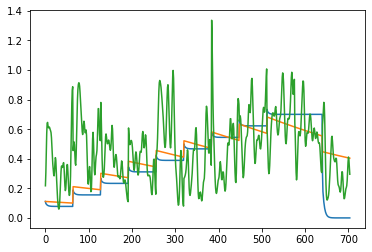

In [8]:
participant = 42
itr = 0
plt.plot(model_errors_dual[itr][participant])
plt.plot(model_errors_single[itr][participant])

plt.plot(np.ravel(curvatures_smooth[participant][1:]))

In [9]:
df_single_dual = pd.DataFrame({'Rotation_Estimate': np.ravel(np.concatenate([model_sudden(num_trials, 1, 0.01)[1], dual_model_sudden(num_trials, 0.9, 0.1, 1, 0.01)[1]])),

                               'Error':np.ravel(np.concatenate([model_sudden(num_trials, 1, 0.01)[0],  dual_model_sudden(num_trials, 0.9, 0.1, 1, 0.01)[0]])), 

                               'Trial': np.tile(range(num_trials), 2),
                               'Model': np.repeat(['Single', 'Dual'], num_trials)
                              
                              })


In [6]:
ll_dual = np.zeros((num_itr, 60, num_trials))
ll_single = np.zeros((num_itr, 60, num_trials))
ll_hybrid = np.zeros((num_itr, 60, num_trials))

for i in range(num_itr):
    for participant in range(60):

        ll_dual[i][participant] = stat.norm.logpdf(np.ravel(curvatures_smooth[participant][1:]), model_errors_dual[i][participant], fits_dual[i][participant, -2])
        ll_single[i][participant] = stat.norm.logpdf(np.ravel(curvatures_smooth[participant][1:]), model_errors_single[i][participant], fits_single[i][participant, -2])
        ll_hybrid[i][participant] = stat.norm.logpdf(np.ravel(curvatures_smooth[participant][1:]), model_errors_hybrid[i][participant], fits_hybrid[i][participant, -2])
        
        #ll_alpha[i][participant] = stat.norm.logpdf(np.ravel(curvatures_smooth[participant][1:]), model_errors_alpha[i][participant], fits_alpha[i][participant, -2])
        
        #ll_mix[i][participant] = stat.norm.logpdf(np.ravel(curvatures_smooth[participant][1:]), model_errors_mixed[i][participant], fits_mixed[i][participant, -2])
        #ll_six[i][participant] = stat.norm.logpdf(np.ravel(curvatures_smooth[participant][1:]), model_errors_six[i][participant], fits_six[i][participant, -2])
        #ll_six[i][participant] = stat.norm.logpdf(np.ravel(curvatures_smooth[participant][1:]), model_errors_six[i][participant], fits_dual[i][participant, -2])

        #ll_dual_avg[i][participant] = stat.norm.logpdf(np.ravel(curvatures_smooth[participant][1:]), model_errors_avg[i][participant], fits_avg[i][participant, -2])
        #ll_eight[i][participant] = stat.norm.logpdf(np.ravel(curvatures_smooth[participant][1:]), model_errors_eight[i][participant], fits_eight[i][participant, -2])

In [7]:
def get_lls(fits, ll, rotate):
    ll_rotate_train = np.zeros((num_itr, 60))
    ll_transfer_train = np.zeros((num_itr, 60))
    ll_rotate_test = np.zeros((num_itr, 60))
    ll_transfer_test = np.zeros((num_itr, 60))
    ll_all_test = np.zeros((num_itr, 60))
    ll_all_train = np.zeros((num_itr, 60))

    for i in range(num_itr):
        for participant in range(60):
            rotate_train_indices = fits[i][participant, -1][fits[i][participant, -1] < 640]
            transfer_train_indices = fits[i][participant, -1][fits[i][participant, -1] >= 640]
            
            all_test_indices = np.delete(range(num_trials), fits[i][participant, -1])
            rotate_test_indices = all_test_indices[all_test_indices<640]
            transfer_test_indices = all_test_indices[all_test_indices>=640]
            #if rotate:
            ll_rotate_train[i][participant] = sum(ll[i][participant][rotate_train_indices])
            ll_rotate_test[i][participant] = sum(ll[i][participant][rotate_test_indices])
            #else:
            ll_transfer_train[i][participant] = sum(ll[i][participant][transfer_train_indices])
            ll_transfer_test[i][participant] = sum(ll[i][participant][transfer_test_indices])
            #Uncomment for combined rotate + transfer
            ll_all_test[i][participant] = sum(ll[i][participant][all_test_indices])
            ll_all_train[i][participant] = sum(ll[i][participant][fits[i][participant, -1]])
    return [ll_rotate_train, ll_rotate_test, ll_transfer_train, ll_transfer_test, ll_all_train, ll_all_test]

In [63]:
np.shape(dual_lls[0] < single_lls[0])

(100, 60)

In [8]:
dual_lls = get_lls(fits_dual, ll_dual, 0)
single_lls = get_lls(fits_single, ll_single, 0)
hybrid_lls = get_lls(fits_hybrid, ll_hybrid, 0)

#dual_lls = get_lls(fits_dual, ll_dual, 0)
#single_lls = get_lls(fits_single, ll_single, 0)
#alpha_lls = get_lls(fits_alpha, ll_alpha, 0)
#eight_lls = get_lls(fits_eight, ll_eight, 0)

In [9]:
def get_full_split_df(ll_selected, ll_compared, selected_model):
    d = {
        'Participant_ID': np.repeat(np.arange(60), 4),
        'Rotation': np.tile(np.repeat(['Sudden', 'Gradual'], 8), 15),
        'Emphasis': np.tile(np.repeat(['Speed', 'Accuracy'], 4), 30),
        'Phase': np.tile(np.repeat(['Rotate', 'Transfer'], 2), 60),
        'Set': np.tile(['Train', 'Test'], 120),
        }
    dual_test_selected = np.zeros(60)
    for i in range(100):
        for p in range(60):
            if ll_compared[0][i][p] < ll_selected[0][i][p]:
                if ll_compared[1][i][p] < ll_selected[1][i][p]:
                    dual_test_selected[p] = dual_test_selected[p] + 1
            #else:
             #   dual_test_selected[p] = dual_test_selected[p] + 0.5
                
    df = pd.DataFrame(d)

    df[selected_model] = np.concatenate((
    sum(ll_compared[0] <= ll_selected[0]), 
    dual_test_selected,
    sum(ll_compared[2] <= ll_selected[2]),
    sum(ll_compared[3] <= ll_selected[3]),

    ))
    return df

In [10]:
def get_train_test_split(ll_selected, ll_compared, model_selected):
    d = {'Rotation': np.ravel(np.row_stack((np.repeat('Sudden', 60), np.repeat('Gradual', 60)))),
     'Emphasis': np.ravel(np.row_stack((np.repeat('Speed', 30), np.repeat('Accuracy', 30), np.repeat('Speed', 30), np.repeat('Accuracy', 30)))),
     'Set': np.ravel(np.row_stack((np.repeat('Train', 15), np.repeat('Test', 15), np.repeat('Train', 15), np.repeat('Test', 15), np.repeat('Train', 15), np.repeat('Test', 15), np.repeat('Train', 15), np.repeat('Test', 15))))}
    df = pd.DataFrame(d)
    df[model_selected] = np.concatenate((
    sum(ll_compared[4][:, 0::4] <= ll_selected[4][:, 0::4]), 
    sum(ll_compared[5][:, 0::4] <= ll_selected[5][:, 0::4]),

    sum(ll_compared[4][:, 1::4] <= ll_selected[4][:, 1::4]), 
    sum(ll_compared[5][:, 1::4] <= ll_selected[5][:, 1::4]),

    sum(ll_compared[4][:, 2::4] <= ll_selected[4][:, 2::4]), 
    sum(ll_compared[5][:, 2::4] <= ll_selected[5][:, 2::4]),

    sum(ll_compared[4][:, 3::4] <= ll_selected[4][:, 3::4]), 
    sum(ll_compared[5][:, 3::4] <= ll_selected[5][:, 3::4]),
    ))
    return df

In [11]:
df_full_split = get_full_split_df(dual_lls, single_lls, "Dual_Selected")
df_train_test = get_train_test_split(dual_lls, single_lls, "Dual_Selected")

In [106]:
df_full_split['Single_Selected'] = 100 - df_full_split['Dual_Selected']

In [86]:
df_full_split.loc[df_full_split.query("Set == 'Train' & Phase == 'Rotate' & Single_Selected > 50").index]

,Participant_ID,Rotation,Emphasis,Phase,Set,Dual_Selected,Single_Selected
0,0,Sudden,Speed,Rotate,Train,7.0,93.0
12,3,Gradual,Accuracy,Rotate,Train,19.0,81.0
28,7,Gradual,Accuracy,Rotate,Train,1.0,99.0
36,9,Sudden,Accuracy,Rotate,Train,0.0,100.0
40,10,Gradual,Speed,Rotate,Train,10.0,90.0
44,11,Gradual,Accuracy,Rotate,Train,1.0,99.0
48,12,Sudden,Speed,Rotate,Train,0.0,100.0
60,15,Gradual,Accuracy,Rotate,Train,6.0,94.0
64,16,Sudden,Speed,Rotate,Train,38.0,62.0
72,18,Gradual,Speed,Rotate,Train,14.0,86.0


In [12]:
df_full_split.loc[df_full_split.query("Set == 'Train' & Phase == 'Rotate' & Dual_Selected > 60").index]

,Participant_ID,Rotation,Emphasis,Phase,Set,Dual_Selected
8,2,Gradual,Speed,Rotate,Train,86.0
16,4,Sudden,Speed,Rotate,Train,70.0
20,5,Sudden,Accuracy,Rotate,Train,62.0
24,6,Gradual,Speed,Rotate,Train,75.0
32,8,Sudden,Speed,Rotate,Train,97.0
52,13,Sudden,Accuracy,Rotate,Train,100.0
56,14,Gradual,Speed,Rotate,Train,70.0
68,17,Sudden,Accuracy,Rotate,Train,78.0
92,23,Gradual,Accuracy,Rotate,Train,81.0
112,28,Sudden,Speed,Rotate,Train,95.0


In [ ]:
sns.set_context('paper')
g = sns.catplot(x="Rotation", y="Dual_Selected", hue="Emphasis", col="Set", 
                capsize=.2, height=6, aspect=.75,ci = 95,
                kind = 'bar', data=df_full_split)
plt.subplots_adjust(top=0.93)
plt.ylim((0, num_itr))
g.fig.suptitle('Compared to Single')


In [16]:
sum(df_full_split.query("Phase == 'Rotate' & Set == 'Train'")['Dual_Selected'] < 41)


28

In [40]:
8/15

0.5333333333333333

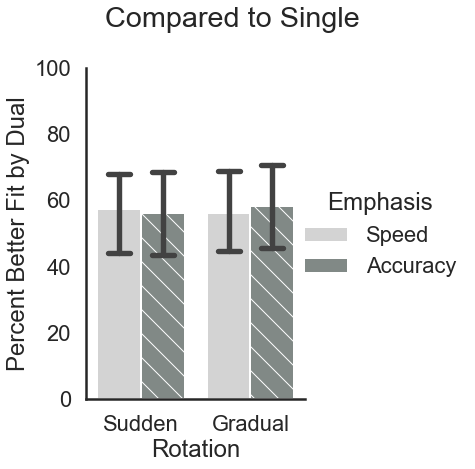

In [93]:
from itertools import cycle
sns.set_context('poster')
sns.set_style('white')
#
colors = ['#D3D3D3', '#808A87']
sns.set_palette(sns.color_palette(colors))

g = sns.catplot(x="Rotation", y="Dual_Selected", hue="Emphasis",
                capsize=.2, height=6, aspect=.75,ci = 95,
                kind = 'bar', data=df_full_split[df_full_split['Set'] == 'Test'])

hatches = cycle(['', '\\'])
num_locations = len(df_train_test.Rotation.unique())
for i, patch in enumerate(g.ax.patches):
    if i % num_locations == 0:
        hatch = next(hatches)
    patch.set_hatch(hatch)
    
plt.subplots_adjust(top=0.91)
plt.ylim((0, num_itr))
g.fig.suptitle('Compared to Single', y = 1.05)
g.set_ylabels('Percent Better Fit by Dual')
plt.savefig('percent_better_fit_by_dual.png', dpi = 600, bbox_inches = 'tight')

In [59]:
dual_selected_testset = df_train_test[df_train_test['Set'] == 'Test']
dual_selected_testset.to_csv('dual_selected_testset.csv')

In [160]:
dual_selected_testset = df_train_test[df_train_test['Set'] == 'Test']
dual_selected_testset['Condition'] = dual_selected_testset['Rotation'] + '_' + dual_selected_testset['Emphasis']
dual_selected_testset = dual_selected_testset.reset_index()


<ipython-input-160-73818549006e>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dual_selected_testset['Condition'] = dual_selected_testset['Rotation'] + '_' + dual_selected_testset['Emphasis']


In [51]:
errors = pd.read_csv('Curvature_Errors.csv')
errors['Condition'] = errors['Rotation'] + '_' + errors['Emphasis']
blockwise_errors = errors.groupby(['Participant_Id', 'Block', 'Rotation', 'Emphasis', 'Condition']).median().reset_index()

In [52]:
participant_errors = blockwise_errors.groupby(['Participant_Id', 'Rotation', 'Emphasis', 'Condition']).mean().reset_index()

In [54]:
blockwise_errors[blockwise_errors['Block'] == 10]

,Participant_Id,Block,Rotation,Emphasis,Condition,Unnamed: 0,Trial,Errors
10,0,10,Sudden,Speed,Sudden_Speed,671.5,671.5,1.061347
22,1,10,Sudden,Accuracy,Sudden_Accuracy,1439.5,671.5,0.143999
34,2,10,Gradual,Speed,Gradual_Speed,2207.5,671.5,0.340296
46,3,10,Gradual,Accuracy,Gradual_Accuracy,2975.5,671.5,0.090651
58,4,10,Sudden,Speed,Sudden_Speed,3743.5,671.5,0.515329
70,5,10,Sudden,Accuracy,Sudden_Accuracy,4511.5,671.5,0.059671
82,6,10,Gradual,Speed,Gradual_Speed,5279.5,671.5,0.220137
94,7,10,Gradual,Accuracy,Gradual_Accuracy,6047.5,671.5,0.097191
106,8,10,Sudden,Speed,Sudden_Speed,6815.5,671.5,0.041856
118,9,10,Sudden,Accuracy,Sudden_Accuracy,7583.5,671.5,0.092872


In [169]:
conc = merged_dual.append(merged_single)

In [170]:
conc.to_csv('conc.csv')

In [44]:
conc = pd.read_csv('conc.csv')

In [47]:
df_train_test[df_train_test['Set'] == 'Test']

,Rotation,Emphasis,Set,Dual_Selected
15,Sudden,Speed,Test,23
16,Sudden,Speed,Test,46
17,Sudden,Speed,Test,97
18,Sudden,Speed,Test,3
19,Sudden,Speed,Test,10
20,Sudden,Speed,Test,90
21,Sudden,Speed,Test,50
22,Sudden,Speed,Test,81
23,Sudden,Speed,Test,50
24,Sudden,Speed,Test,86


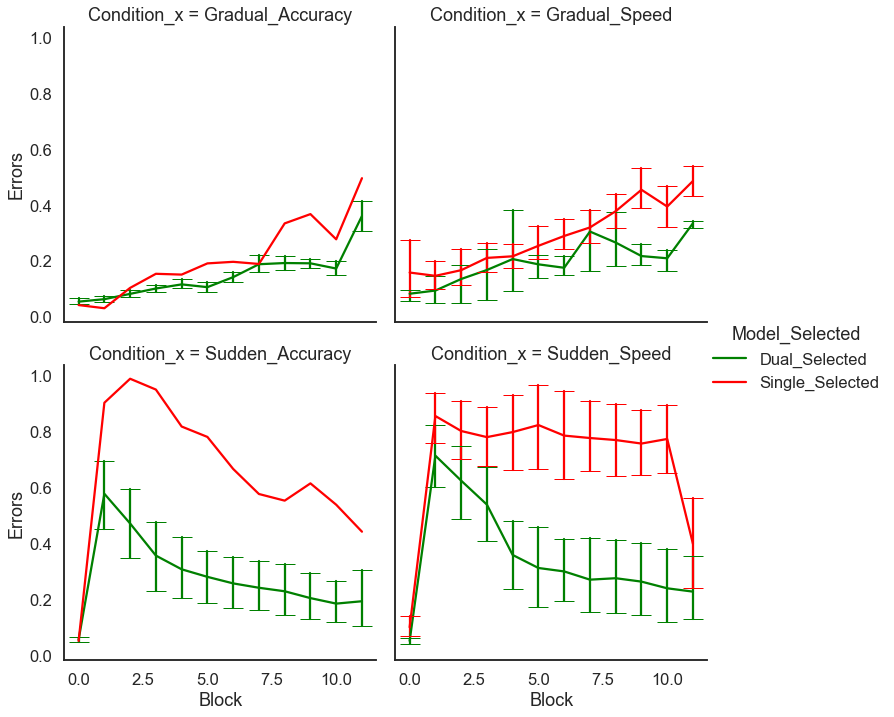

In [30]:
sns.set_context('talk')
sns.set_style('white')
sns.relplot(x = 'Block', y = 'Errors',  hue = 'Model_Selected', col = 'Condition_x', palette=['Green', 'Red'],
            kind = 'line', markers = True, err_style = 'bars', err_kws = {"capsize": 10}, 
             col_wrap=2, col_order=['Gradual_Accuracy', 'Gradual_Speed', 'Sudden_Accuracy', 'Sudden_Speed'], 
             data = conc)


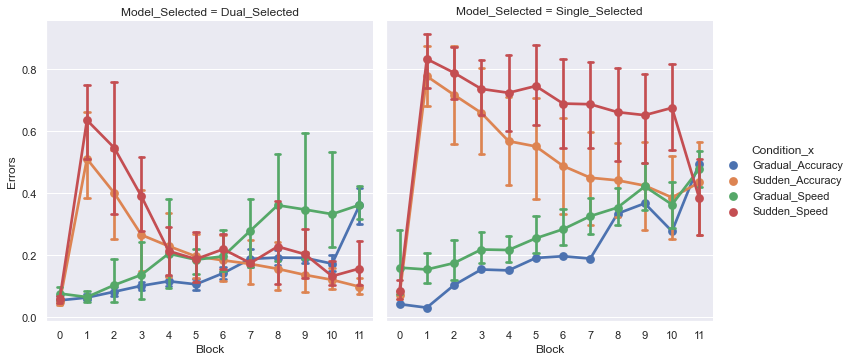

In [63]:
sns.catplot(x = 'Block', y = 'Errors', hue = 'Condition_x', kind = 'point', 
            capsize = 0.2, col = 'Model_Selected',
            data = conc)

In [34]:
model = smf.ols('Eight_Selected ~ Rotation*Emphasis', data=df_train_test[df_full_split['Set'] == 'Test']).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
anova_table

<ipython-input-34-d1907dea8f1d>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  model = smf.ols('Eight_Selected ~ Rotation*Emphasis', data=df_train_test[df_full_split['Set'] == 'Test']).fit()


,sum_sq,df,F,PR(>F)
Rotation,375.000000,1.0,0.342537,0.560719
Emphasis,25297.066667,1.0,23.107167,0.000012
Rotation:Emphasis,2257.066667,1.0,2.061678,0.156606
Residual,61307.200000,56.0,NaN,NaN


In [23]:
SS = df_train_test['Dual_Selected'][df_train_test['Set'] == 'Test'][df_train_test['Emphasis'] == 'Speed'][df_train_test['Rotation'] == 'Sudden']
GS = df_train_test['Dual_Selected'][df_train_test['Set'] == 'Test'][df_train_test['Emphasis'] == 'Speed'][df_train_test['Rotation'] == 'Gradual']
SA = df_train_test['Dual_Selected'][df_train_test['Set'] == 'Test'][df_train_test['Emphasis'] == 'Accuracy'][df_train_test['Rotation'] == 'Sudden']
GA = df_train_test['Dual_Selected'][df_train_test['Set'] == 'Test'][df_train_test['Emphasis'] == 'Accuracy'][df_train_test['Rotation'] == 'Gradual']


In [24]:
statsmodels.stats.proportion.proportions_chisquare([np.mean(SS), np.mean(SG), np.mean(AS), np.mean(AG)],[100, 100, 100, 100])

NameError: name 'SG' is not defined

(-1.0, 1.0)

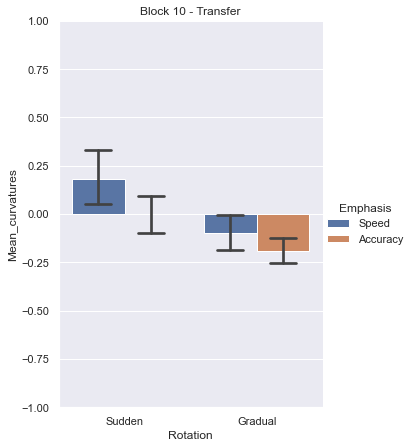

In [139]:
block = 11
d = {'Rotation': np.ravel(np.row_stack((np.repeat('Sudden', 30), np.repeat('Gradual', 30)))),
     'Emphasis': np.ravel(np.row_stack((np.repeat('Speed', 15), np.repeat('Accuracy', 15), np.repeat('Speed', 15), np.repeat('Accuracy', 15)))),
     
    'Mean_curvatures': np.concatenate((np.mean(curvatures_smooth[0::4], axis = 2)[:, block-1] - np.mean(curvatures_smooth[0::4], axis = 2)[:, block],
                np.mean(curvatures_smooth[1::4], axis = 2)[:, block-1] - np.mean(curvatures_smooth[1::4], axis = 2)[:, block],
                np.mean(curvatures_smooth[2::4], axis = 2)[:, block-1] - np.mean(curvatures_smooth[2::4], axis = 2)[:, block],
                np.mean(curvatures_smooth[3::4], axis = 2)[:, block-1] - np.mean(curvatures_smooth[3::4], axis = 2)[:, block],
             ))

    }

df_last_rotate = pd.DataFrame(d)
g = sns.catplot(x="Rotation", y="Mean_curvatures", hue="Emphasis",
                capsize=.2, height=6, aspect=.75,ci = 95,
                kind = 'bar', data=df_last_rotate)
plt.title('Block 10 - Transfer')
plt.ylim((-1, 1))

In [140]:
model = smf.ols('Mean_curvatures ~ Rotation*Emphasis', data=df_last_rotate).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
anova_table

,sum_sq,df,F,PR(>F)
Rotation,0.821691,1.0,18.930433,0.000058
Emphasis,0.282815,1.0,6.515604,0.013447
Rotation:Emphasis,0.031229,1.0,0.719476,0.399927
Residual,2.430727,56.0,NaN,NaN


In [95]:
np.mean(df_last_rotate['Mean_curvatures'][46:60])

-0.17998015909867204

In [151]:
a, b = stats.chisquare([GS, GA, SS, SA])

In [95]:
for i in range(100):
    print (i, fits_dual[i][48][-3] - fits_single[i][48][-3])

0 -23.66660017616404
1 -26.664066180320432
2 -21.836731526024934
3 -25.712168566850536
4 -30.58341533212888
5 45.940601502010054
6 -23.473992444893383
7 10.43840048513296
8 924.3912037866637
9 10.463430697453902
10 -27.551189698258966
11 0.02993305899227039
12 -25.476737866865875
13 22.599076184352086
14 -24.1403291642318
15 -32.786031691982885
16 15.52434207309426
17 963.5957996623853
18 -27.0795945740702
19 207.79183683437725
20 905.6556644118723
21 6.839768229348266
22 -28.991889900568637
23 40.18247294257422
24 -24.317230078779545
25 -30.486442607751385
26 -24.97080910813652
27 -27.967783776409448
28 -26.524282359971323
29 -27.599631756747954
30 -28.537459051997416
31 -28.619033213672637
32 -33.93095348459737
33 126.28784534370938
34 971.6738580727127
35 39.37635649749633
36 -31.016939701844564
37 -28.056129914109306
38 44.78472797959493
39 -20.812351494342238
40 971.7114493295155
41 -26.68154267780173
42 -34.28364200454992
43 -30.70948901012241
44 -27.204432904568705
45 -21.957117

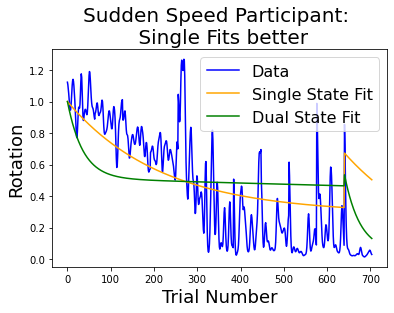

In [97]:
participant = 48
itr = 76
fig, ax = plt.subplots()
ax.plot(np.ravel(curvatures_smooth[participant][1:]), color = 'blue', label = 'Data')
ax.plot(model_errors_single[itr][participant], color = 'orange', label = 'Single State Fit')
ax.plot(model_errors_dual[itr][participant], color = 'green', label = 'Dual State Fit')
ax.set_title('Sudden Speed Participant: \n Single Fits better', fontsize = 20)
ax.set_xlabel('Trial Number', fontsize = 18)
ax.set_ylabel('Rotation', fontsize = 18)
leg = ax.legend(prop={"size":16})
#plt.legend((p0, p1, p2), ('Data', 'Single State', 'Dual State'))
#plt.title('Rotate')
plt.savefig('Better_single_fit.png', dpi = 600, bbox_inches = 'tight')

Text(0.5, 1.0, 'Transfer')

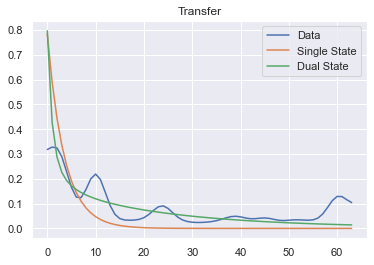

In [48]:
participant = 37

p0, = plt.plot(np.ravel(curvatures_smooth[participant][-1]))
p1, = plt.plot(np.mean(model_errors_single_transfer, axis = 0)[participant])
p2, = plt.plot(np.mean(model_errors_dual_transfer, axis = 0)[participant])

plt.legend((p0, p1, p2), ('Data', 'Single State', 'Dual State'))
plt.title('Transfer')

In [49]:
curvatures_smooth[participant][10][-1]

0.8514456500218309

In [32]:
participant = 53
fits_single_transfer[1][participant][2], fits_dual_transfer[1][participant][4]

(-16.286725535895798, -7.450671493772525)

In [38]:
participant = 14
-2*np.sum(stat.norm.logpdf(curvatures_smooth[participant][-1], model_errors_dual_transfer[0][participant]))

121.11122410290955

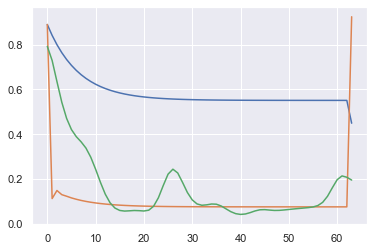

In [164]:
plt.plot(model_transfer(0.89, 64, 0.9210593053638314, 0.06433684145450244)[0])
plt.plot(dual_transfer(0.89, 64, 0.7135521829308, 0.49866691606443314, 0.9526619783821537, 0.4986667586384563,)[0])

plt.plot(curvatures_smooth[participant][-1])

In [158]:
1 - curvatures_smooth[participant][10][-1]

0.8995634881336975

In [117]:
its = pickle.load(open('params/its.pickle', 'rb'))
mts = pickle.load(open('mts.pickle', 'rb'))

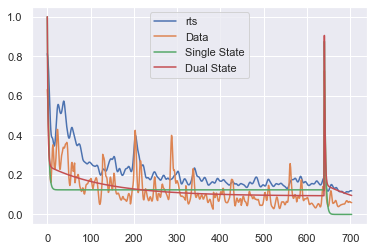

In [157]:
participant = 41
p, = plt.plot(gaussian_filter1d(np.ravel( (mts[participant][1:])/np.max(mts[participant]) + its[20][1:]/np.max(its[participant])), sigma = 3))
#plt.plot(np.ravel(curvatures_smooth[participant][1:]))
p0, = plt.plot(np.ravel(curvatures_smooth[participant][1:]))
p1, = plt.plot(model_errors_single[itr][participant])
p2, = plt.plot(model_errors_dual[itr][participant])
plt.legend((p, p0, p1, p2), ('rts', 'Data', 'Single State', 'Dual State'))


50.24349663838527

In [47]:
fits_dual[0, 5]

10.503401873917536

In [49]:
fits_single[0, 3]

-82.73038327528457

93.2337851492021